# NWES barotropic flow calculation

In [140]:
import xarray as xr
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

## ROMS output

In [2]:
run3 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/run3/NorthSea4_avg.nc')

In [3]:
# Remove years before 1950
run3 = run3.where(run3.ocean_time.dt.year > 1949, drop = True)

# Remove incomplete years
run3 = run3.where(run3.ocean_time.dt.year < 1971, drop = True)

# Obtain monthly and yearly averages
run3_mon = run3.resample(ocean_time='1M').mean()
run3_year = run3.resample(ocean_time='1Y').mean()


## Obtain barotropic volume transport by integrating over depth

Volume transport is obtained by taking the sum over the k index (depth). Huon/Hvom unit is m3/s


Alternatively, volume transport is obtained by multiplying ubar with (h+zeta) and dividing by pm. ubar unit is m/s, h and zeta have unit m and pm has unit /m.


The unit of volume transport is m3/s.




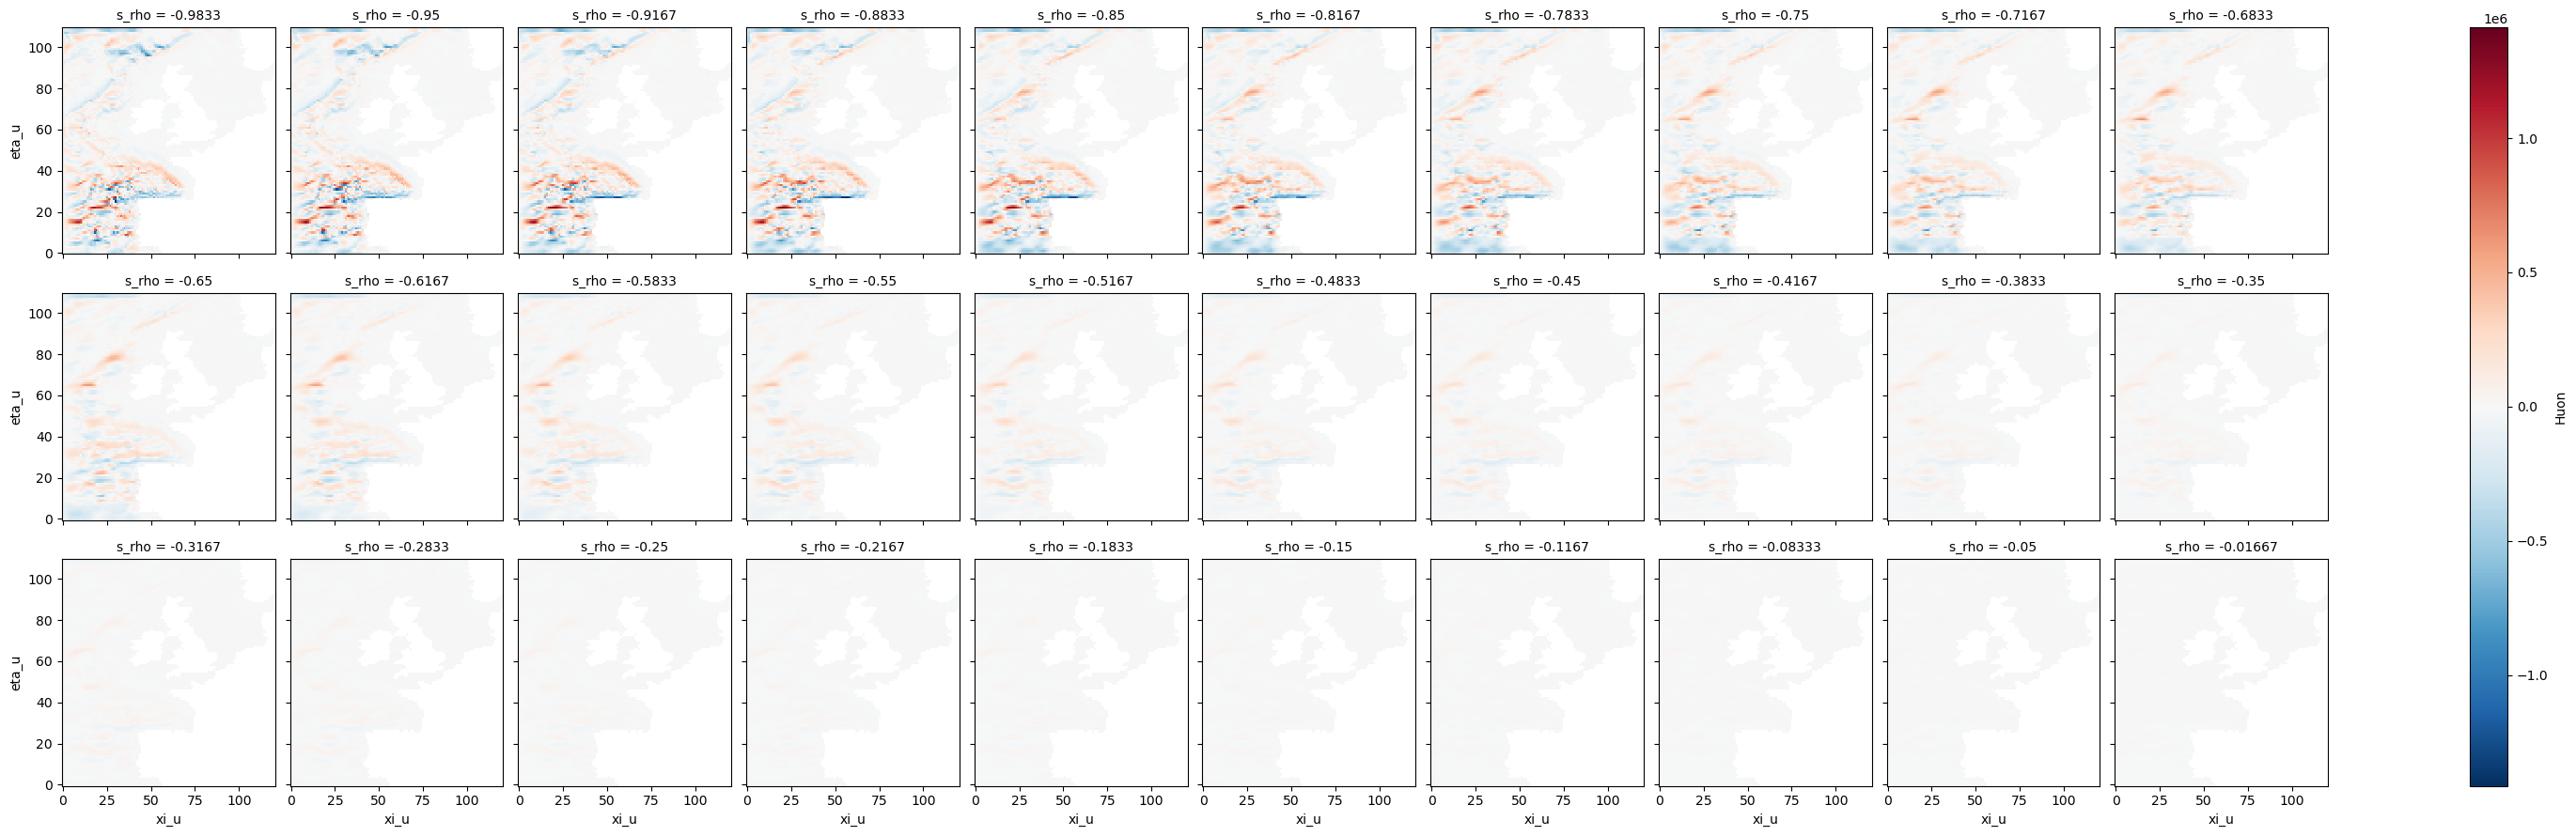

In [12]:
run3_year.Huon.isel(ocean_time=0).plot(col = 's_rho', col_wrap = 10)

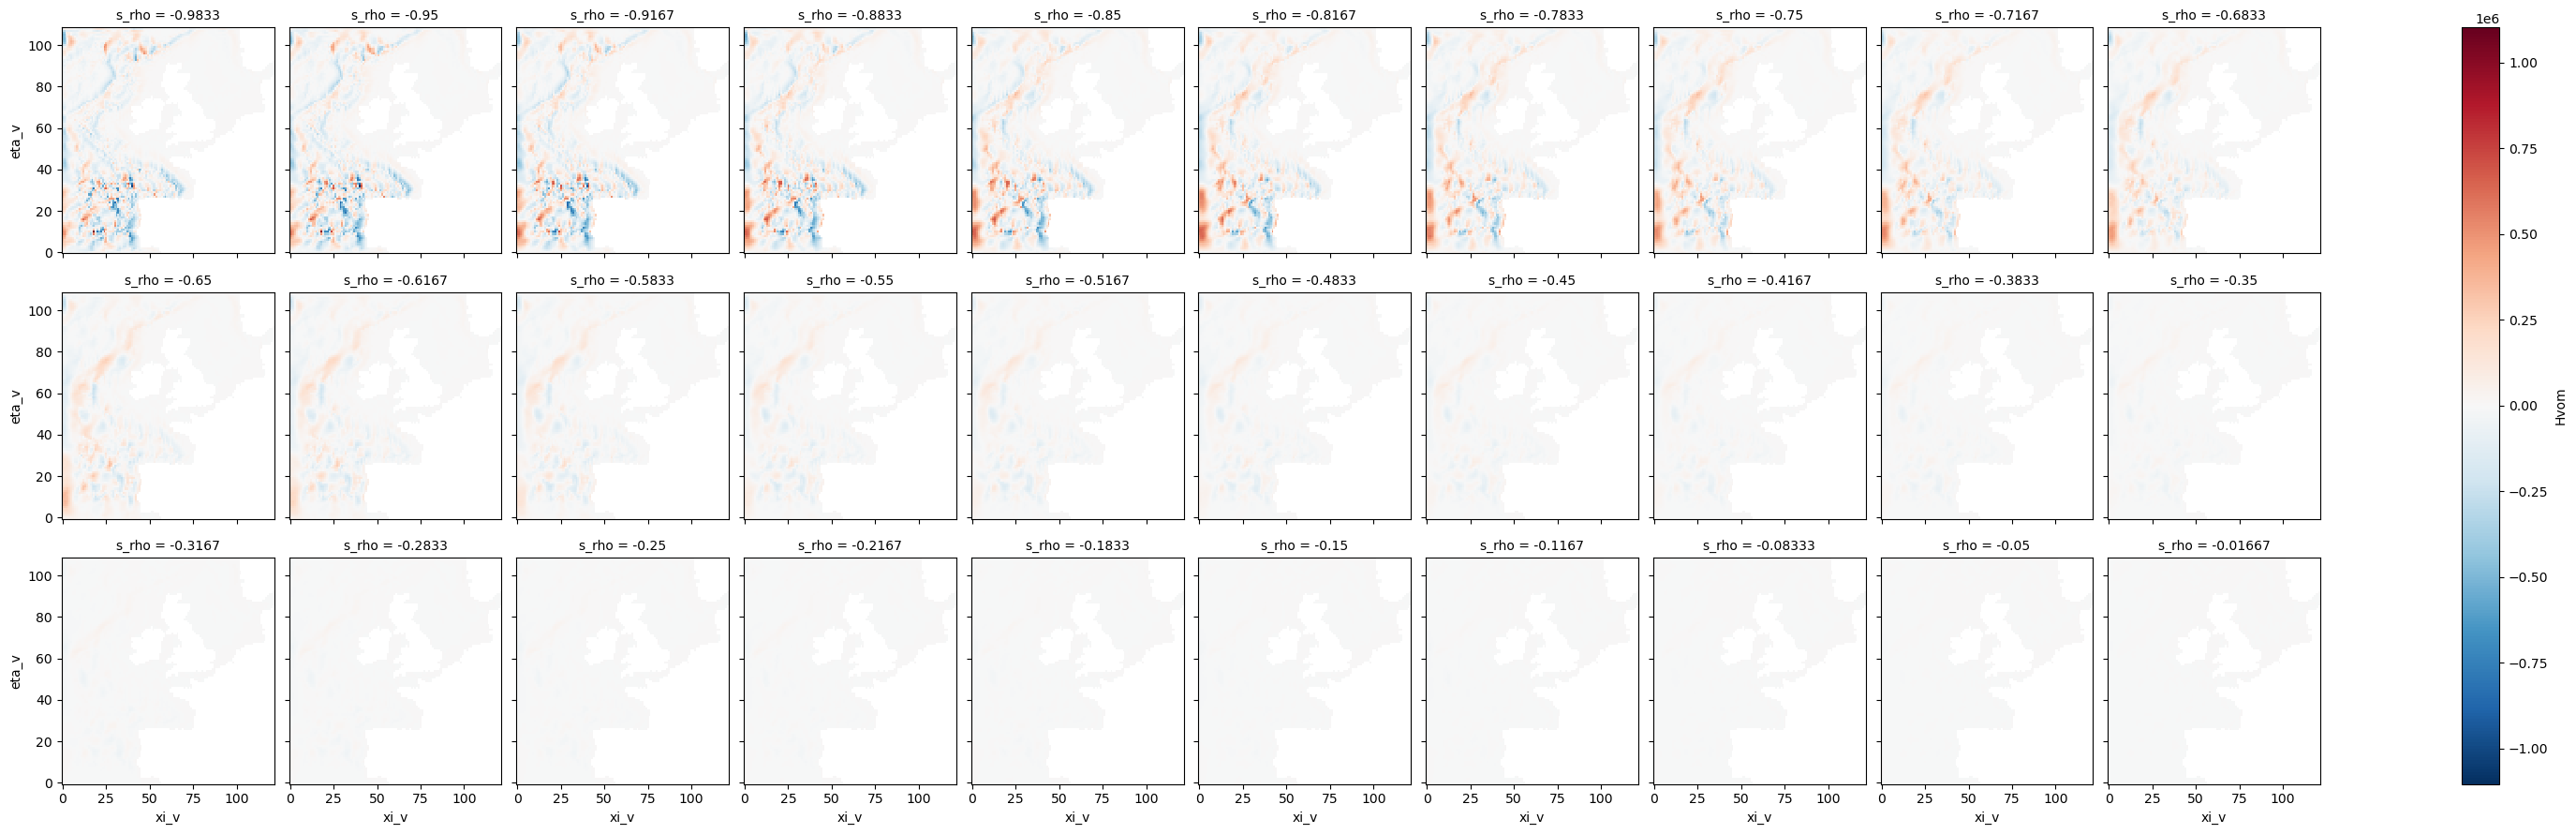

In [4]:
run3_year.Hvom.isel(ocean_time=0).plot(col = 's_rho', col_wrap = 10)

### Volume transport calculation 1: Huon or Hvom divided by pm

In [22]:
volume_transport_x = run3_year.Huon.sum('s_rho', skipna = True, min_count = 1)

volume_transport_y = run3_year.Hvom.sum('s_rho', skipna = True, min_count = 1)


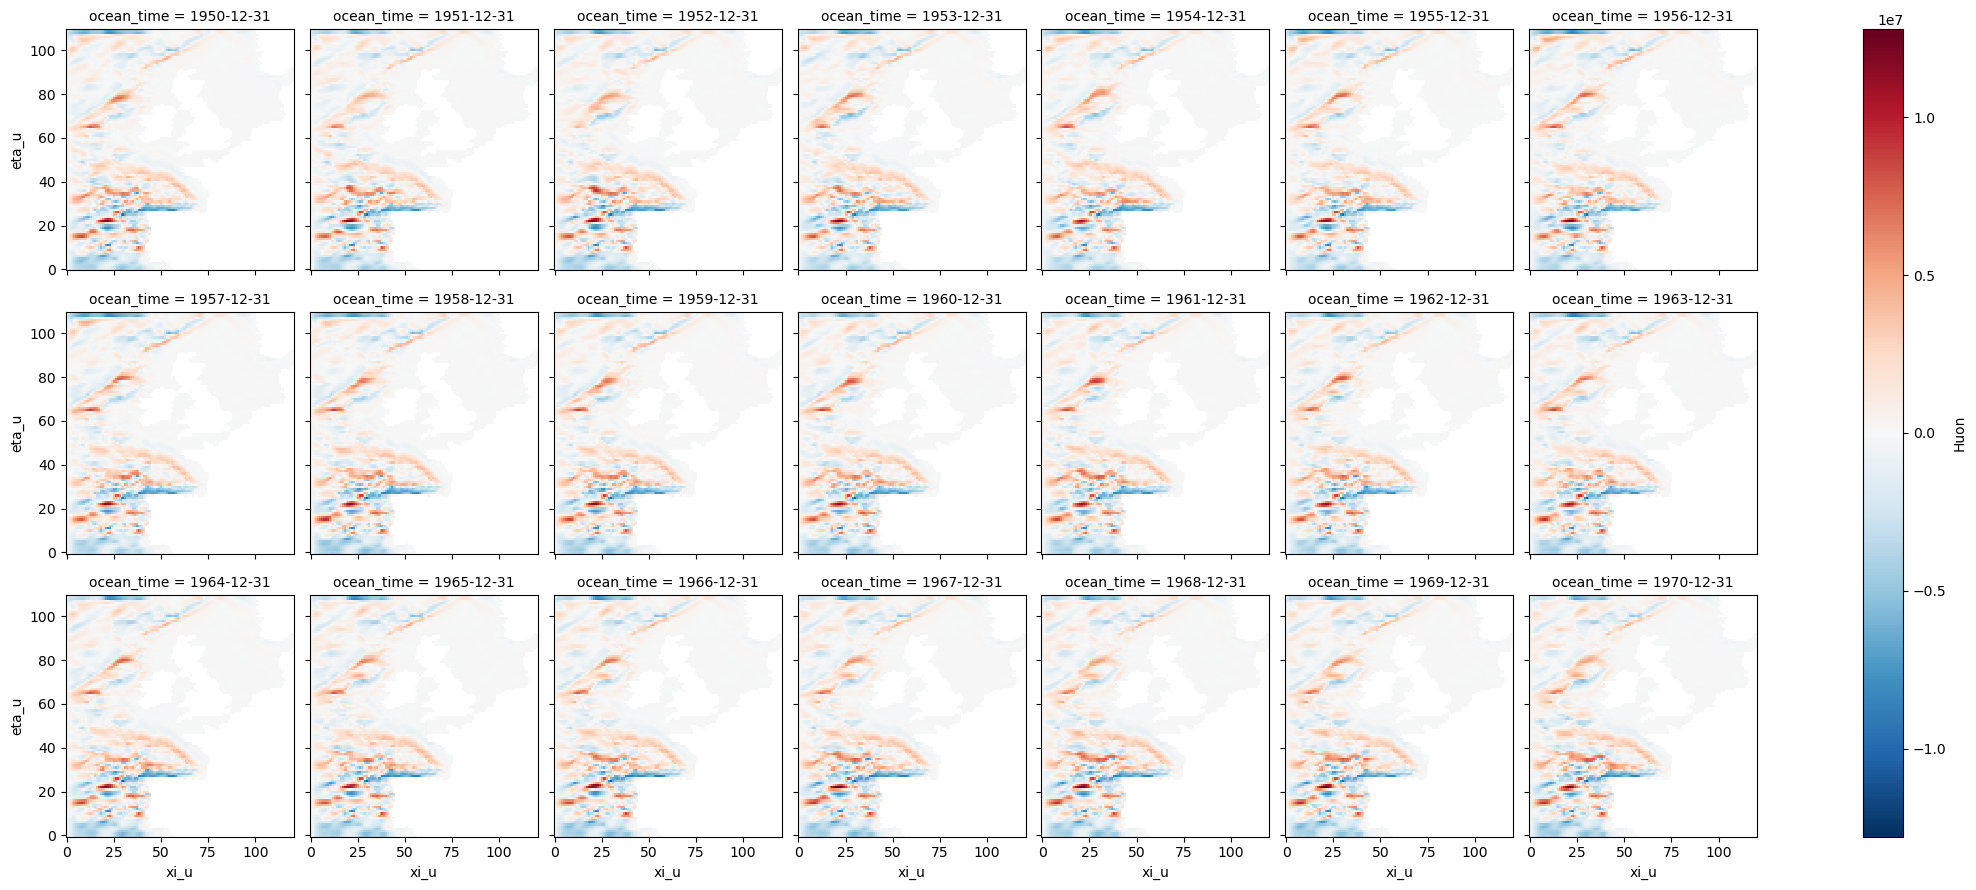

In [24]:
volume_transport_x.plot(col = 'ocean_time', col_wrap = 7)

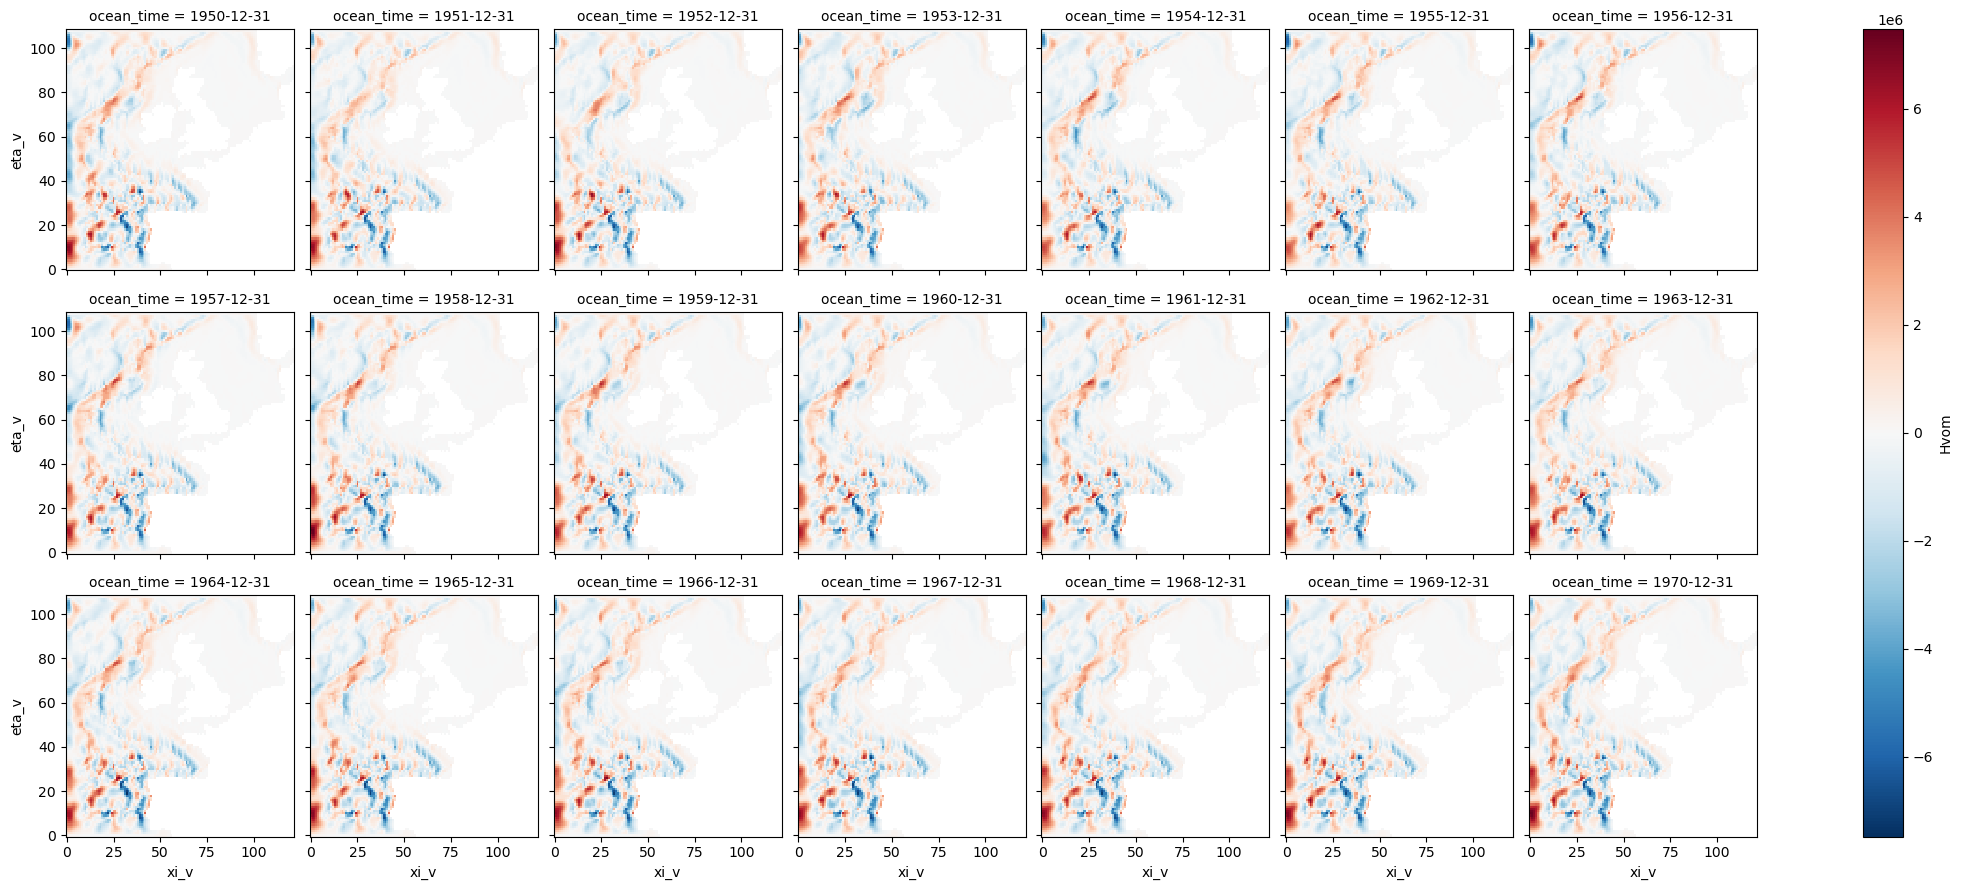

In [25]:
volume_transport_y.plot(col = 'ocean_time', col_wrap = 7)

## ORA20C reanalysis data

In [79]:
ora20c = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ORA20C/forcing input/ora20c.nc')

# Sort coordinates in increasing order
ora20c = ora20c.sortby(['time', 'latitude', 'longitude'])

# Remove years before 1950
ora20c = ora20c.where(ora20c.time.dt.year > 1949, drop = True)

# Remove years after 1994
ora20c = ora20c.where(ora20c.time.dt.year < 1971, drop = True)

# Only use ROMS domain
ora20c = ora20c.where((ora20c.latitude > 36) & (ora20c.latitude < 62) & (ora20c.longitude > -20 ) & (ora20c.longitude < 10) , drop = True) # Select region

# Obtain monthly and yearly averages
ora20c_year = ora20c.resample(time='1Y').mean()

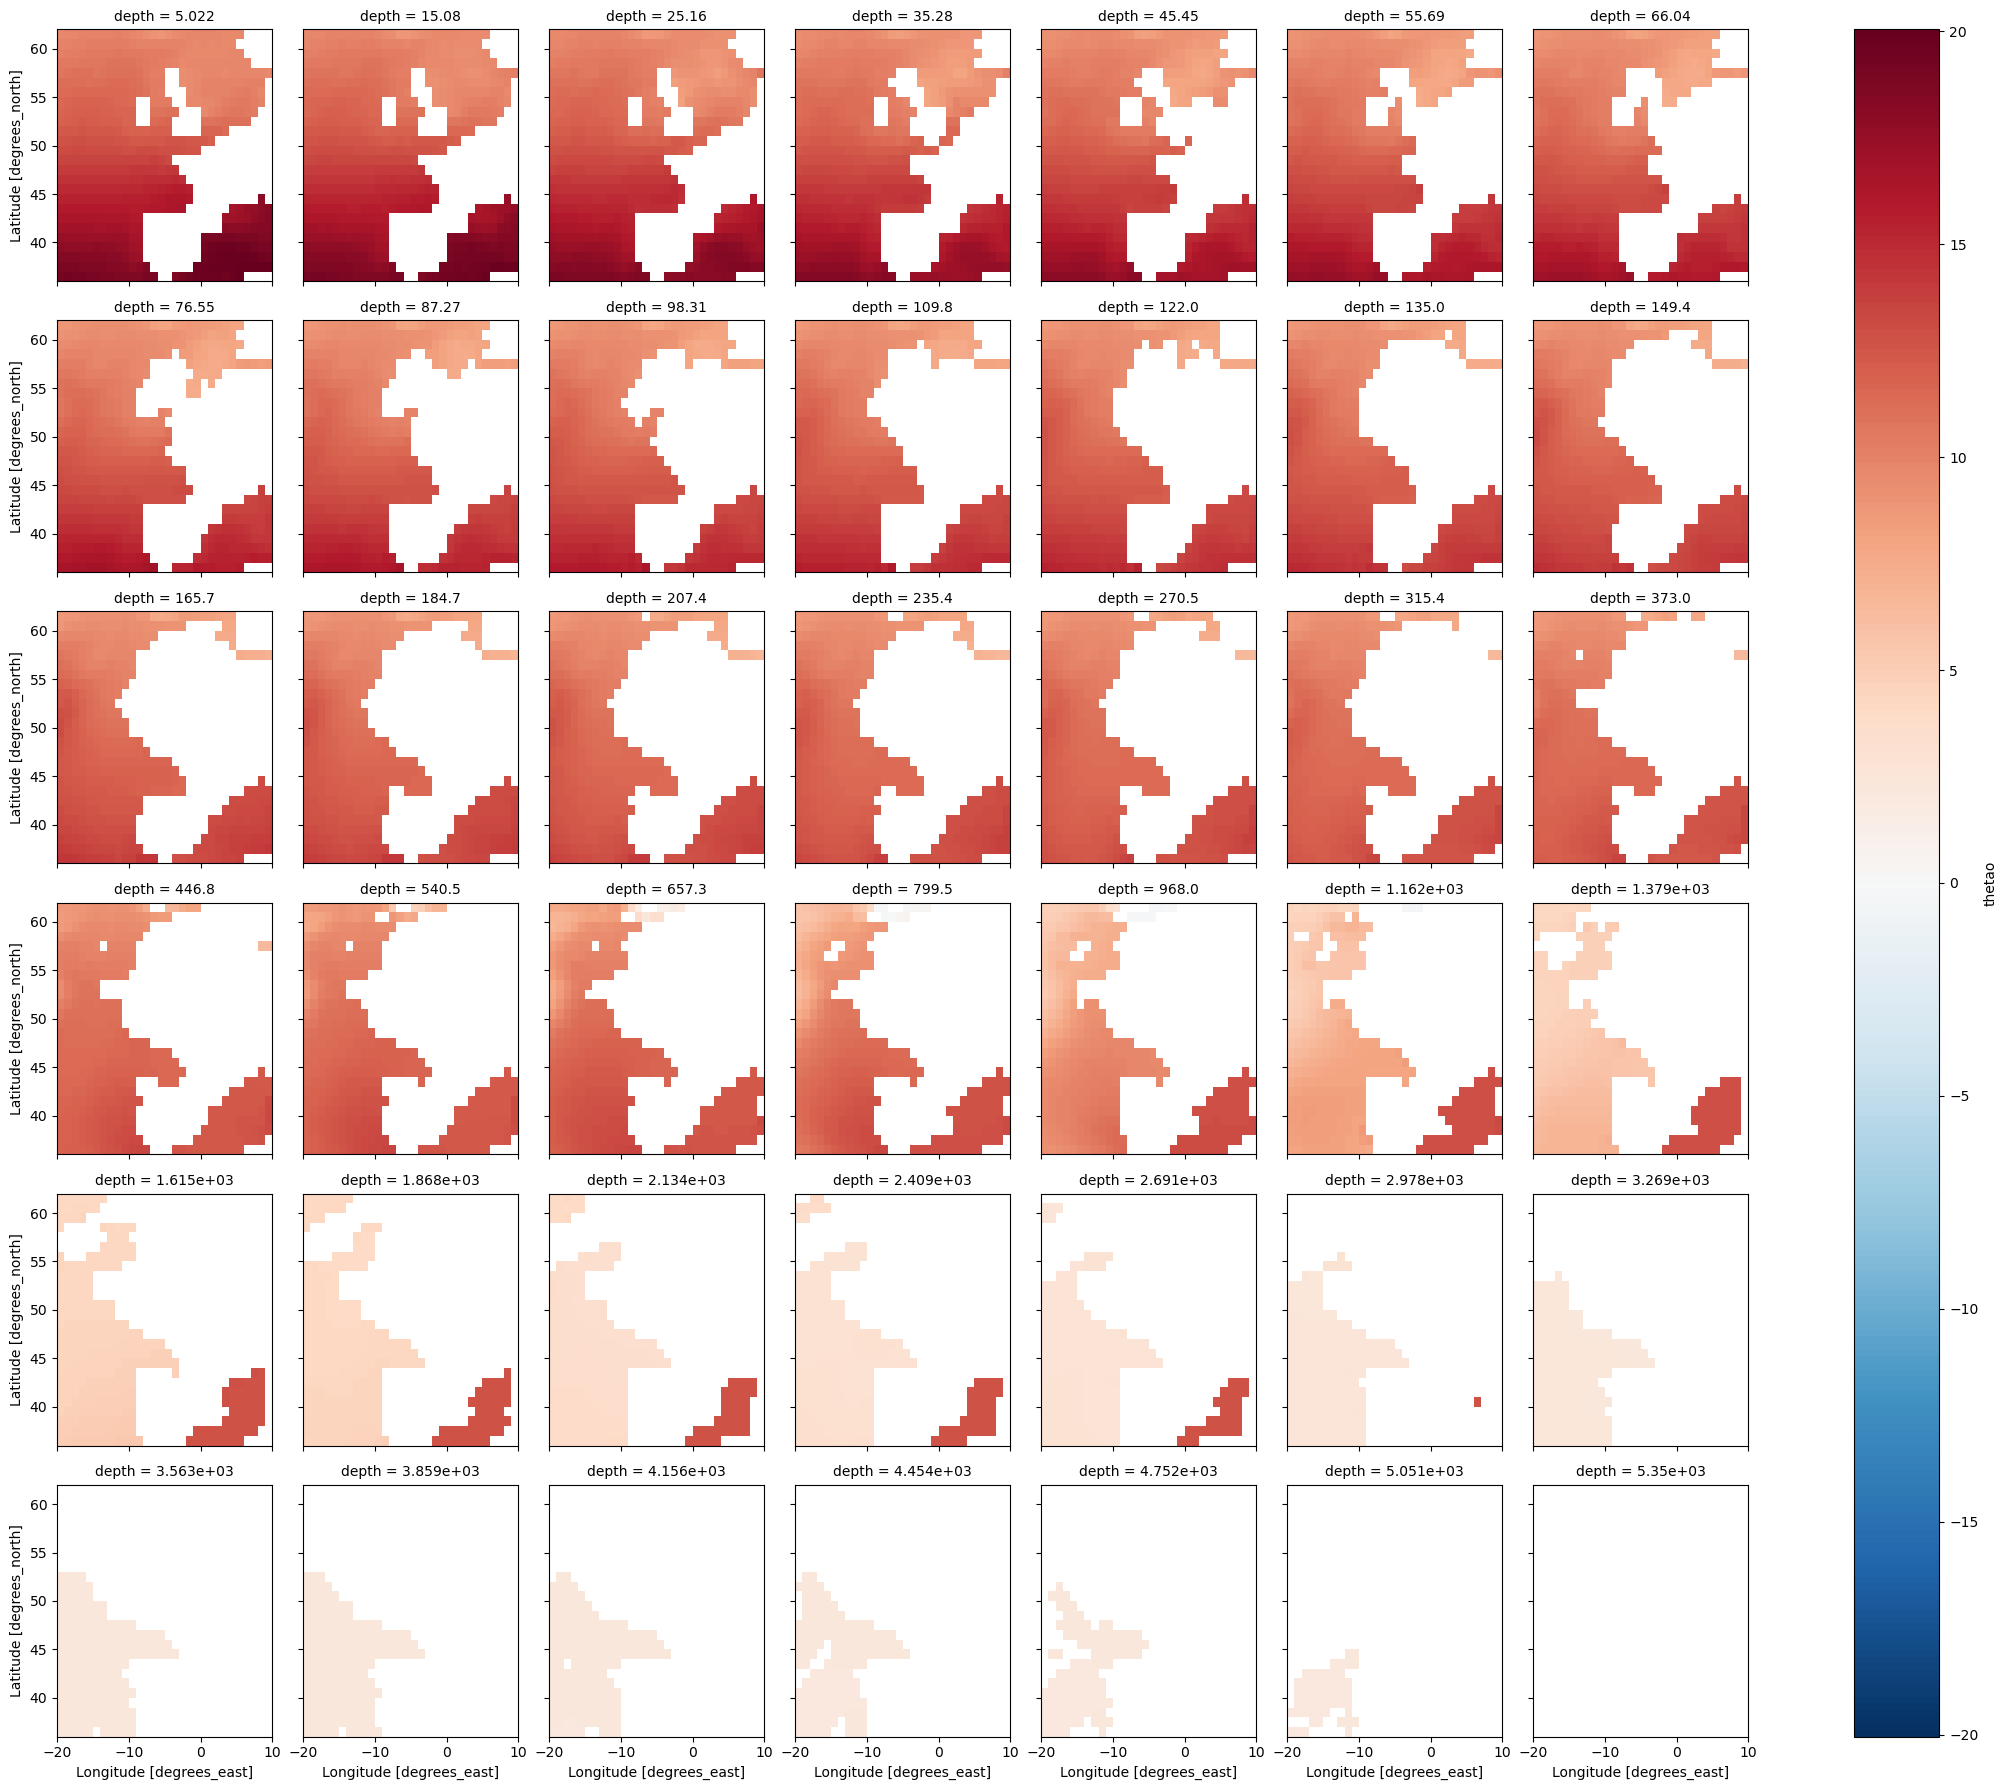

In [80]:
ora20c_year.thetao.isel(time=0).plot(col = 'depth', col_wrap = 7)

In [70]:
def depth_check(data, depths, Ndata):
    '''
    data is 1d array with dimension depth containing data values 
    data should be ordered from deepest to shallowest 
    
    depths is 1d array with depth values in m, should also be ordered from deepest to shallowest
    
    Ndata is size of data
    
    
    Function checks for which depth data contains a value instead of nan and returns bathymetry depth
    
    output is a value
    '''
    
    for i in range (Ndata-1):
        
        if np.isnan(data[i]) and not np.isnan(data[i+1]):
            
            return np.asarray(depths[i])
            


In [71]:
def obtain_bathymetry(data):
    '''
    data is 4d array with dimensions time, depth, latitude and longitude
    
    Function creates bathymetry dataset with dimensions latitude and longitude
    
    '''
    
    data = data.isel(time = 0)
    
    data = data.sortby(['depth'], ascending = False)    # Sort the data from deepest to shallowest
    
    depths = data.depth
    
    bathymetry = xr.apply_ufunc(depth_check,                                                         # The function that should be executed
                             data, depths, data.depth.size,                                                        # The arguments the function needs
                             input_core_dims=[['depth'], ['depth'], []],                     # The list of core dimensions on each input argument that should not be broadcast
                             exclude_dims=set(('depth',)), 
                             output_core_dims = [[]],
                             dask = 'parallelized',
                             output_dtypes = [depths.dtype],
                             vectorize = True)
    
    return bathymetry

In [72]:
thetao = ora20c.thetao

bathymetry = obtain_bathymetry(thetao)

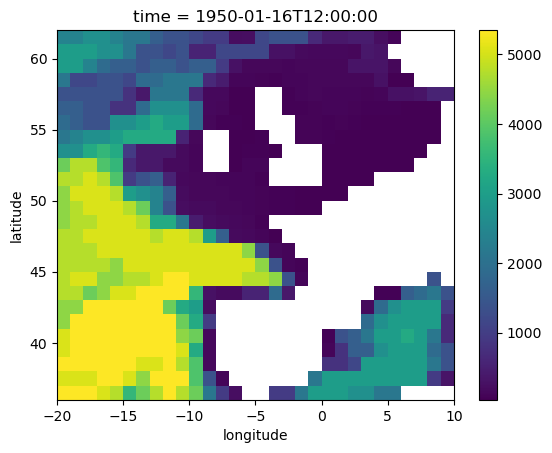

In [73]:
bathymetry.plot()

### Compare bathymetry

In [189]:
def set_extent_and_map_axes(ax):
    
    
    ldom = np.array([[30.0, 67.0], [-25.0, 15.0]])
    ax.set_extent([-21, 11, 35, 63], crs=ccrs.PlateCarree())
    ax.set_xticks([-20, -15, -10, -5, 0, 5, 10], crs=ccrs.PlateCarree())
    ax.set_yticks([35, 40, 45, 50, 55, 60], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    return ax


def add_colorbar(cs, levels, ax, fig):
    steps = 4
    ticks = [float("{:.1f}".format(levels[i])) for i in range(0, len(levels), steps)]

    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="3%", pad=0.1, axes_class=plt.Axes)
    fig.add_axes(ax_cb)
    clb = plt.colorbar(cs,
                       fraction=0.01,
                       orientation="vertical",
                       ticks=ticks,
                       cax=ax_cb)
    clb.ax.set_title("Depth (m)", fontsize=14)




def create_map_grid(ds, depths, levels):

    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax = set_extent_and_map_axes(ax)

    cs1 = ax.contourf(ds.lon_rho.values, ds.lat_rho.values, depths.values,
                      cmap=level_colormap(levels, cmap=plt.cm.get_cmap("RdYlBu")),
                      levels=levels,
                      zorder=2,
                      alpha=1.0,
                      extend="min",
                      transform=ccrs.PlateCarree())

   # ax.scatter(ds.lon_rho.values, ds.lat_rho.values, c="r", s=1, zorder=10, transform=ccrs.PlateCarree())
   #  ax.coastlines(zorder=20, linewidth=2)
   #  ax.add_feature(cfeature.LAND, color="lightgrey", zorder=20)
   #  ax.coastlines(resolution="10m", linewidth=2, color="black", alpha=1.0, zorder=4)
    ax.add_feature(cfeature.GSHHSFeature('high', edgecolor='black'), zorder=20)
    plt.grid(True, zorder=0, alpha=0.5)
    add_colorbar(cs1, levels, ax, fig)
    
def create_map_grid_ora(ds, depths, levels):

    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax = set_extent_and_map_axes(ax)

    cs1 = ax.contourf(ds.longitude.values, ds.latitude.values, depths.values,
                      cmap=level_colormap(levels, cmap=plt.cm.get_cmap("RdYlBu")),
                      levels=levels,
                      zorder=2,
                      alpha=1.0,
                      extend="min",
                      transform=ccrs.PlateCarree())

    # ax.scatter(ds.lon_rho.values, ds.lat_rho.values, c="r", s=1, zorder=10, transform=ccrs.PlateCarree())
    #  ax.coastlines(zorder=20, linewidth=2)
    #  ax.add_feature(cfeature.LAND, color="lightgrey", zorder=20)
    #  ax.coastlines(resolution="10m", linewidth=2, color="black", alpha=1.0, zorder=4)
    ax.add_feature(cfeature.GSHHSFeature('high', edgecolor='black'), zorder=20)
    plt.grid(True, zorder=0, alpha=0.5)
    add_colorbar(cs1, levels, ax, fig)



    
def level_colormap(levels, cmap=None):
    """Make a colormap based on an increasing sequence of levels"""

    # Start with an existing colormap
    if cmap == None:
        cmap = pl.get_cmap()

    # Spread the colours maximally
    nlev = len(levels)
    S = np.arange(nlev, dtype='float') / (nlev - 1)
    A = cmap(S)

    # Normalize the levels to interval [0,1]
    levels = np.array(levels, dtype='float')
    L = (levels - levels[0]) / (levels[-1] - levels[0])

    # Make the colour dictionary
    R = [(L[i], A[i, 0], A[i, 0]) for i in range(nlev)]
    G = [(L[i], A[i, 1], A[i, 1]) for i in range(nlev)]
    B = [(L[i], A[i, 2], A[i, 2]) for i in range(nlev)]
    cdict = dict(red=tuple(R), green=tuple(G), blue=tuple(B))

    # Use
    return matplotlib.colors.LinearSegmentedColormap(
        '%s_levels' % cmap.name, cdict, 256)

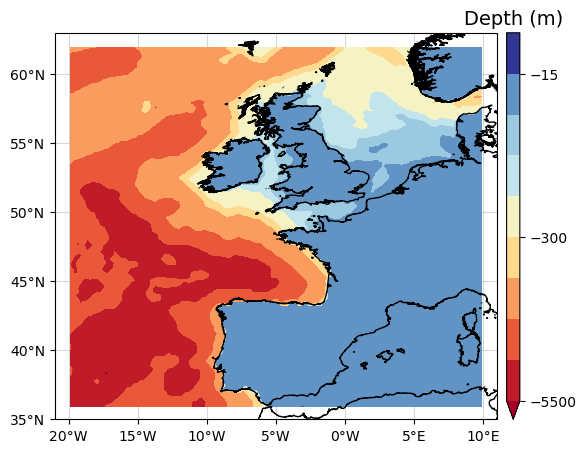

In [191]:
roms_bathymetry = -run3.isel(ocean_time=0).h


levels = [ 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
levels = [ -0, -10, -20, -40, -80, -160, -320, -640, -1280, -2560, -5120, -6000]
levels = [-5500, -4500, -2000, -500, -300, -100, -60, -30, -15, 0]

create_map_grid(run3_year, roms_bathymetry, levels)

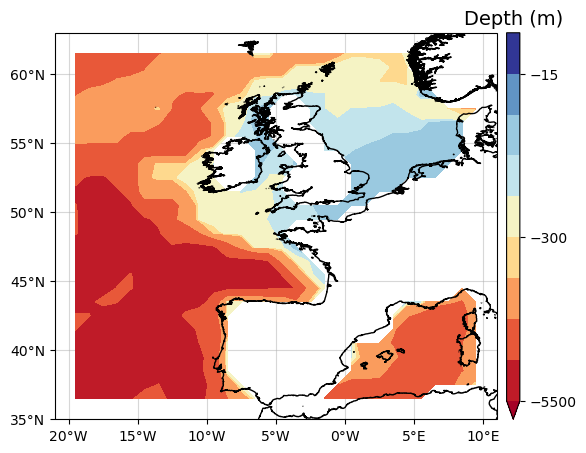

In [192]:
ora_bathymetry = -bathymetry

create_map_grid_ora(ora20c_year, ora_bathymetry, levels)

Text(0.5, 1.0, 'Bathymetry of ORA-20C reanalysis')

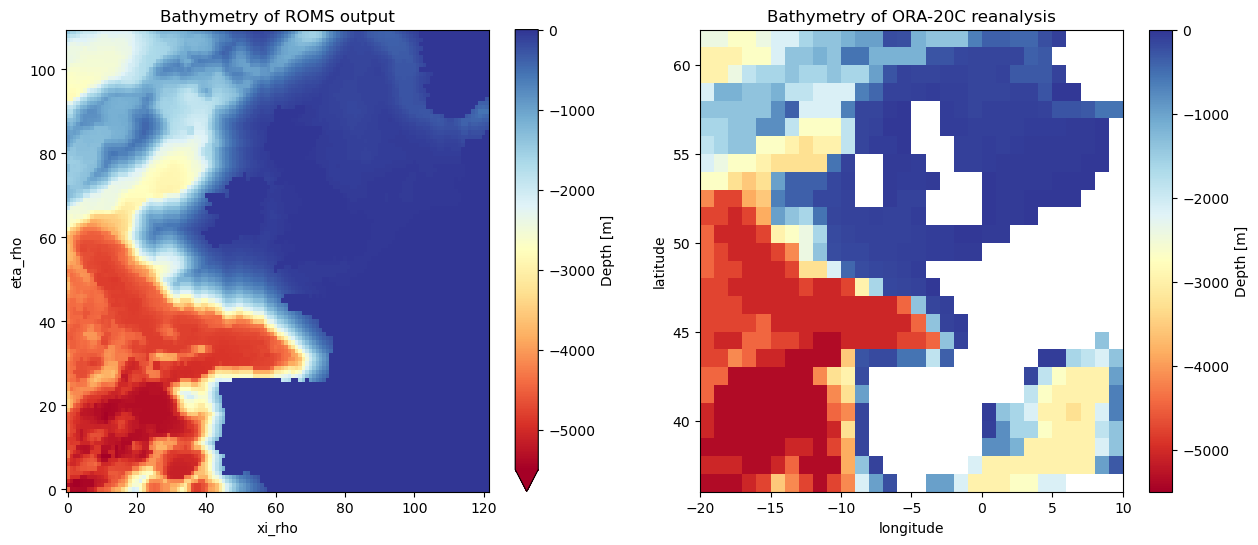

In [212]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 6))


p = roms_bathymetry.plot(ax = axes[0], vmin = -5500, vmax = 0, cmap=plt.cm.get_cmap("RdYlBu"), cbar_kwargs={"label": "Depth [m]"})
axes[0].set_title(f'Bathymetry of ROMS output')



ora_bathymetry.plot(ax = axes[1], vmin = -5500, vmax = 0, cmap=plt.cm.get_cmap("RdYlBu"), cbar_kwargs={"label": "Depth [m]"})
axes[1].set_title(f'Bathymetry of ORA-20C reanalysis')



### Obtain ubar and vbar

In [193]:
ora20c.depth

<xarray.DataArray 'depth' (depth: 42)>
array([5.021590e+00, 1.507854e+01, 2.516046e+01, 3.527829e+01, 4.544776e+01,
       5.569149e+01, 6.604198e+01, 7.654591e+01, 8.727029e+01, 9.831118e+01,
       1.098062e+02, 1.219519e+02, 1.350285e+02, 1.494337e+02, 1.657285e+02,
       1.846975e+02, 2.074254e+02, 2.353862e+02, 2.705341e+02, 3.153741e+02,
       3.729655e+02, 4.468009e+02, 5.405022e+02, 6.573229e+02, 7.995496e+02,
       9.679958e+02, 1.161806e+03, 1.378661e+03, 1.615291e+03, 1.868071e+03,
       2.133517e+03, 2.408583e+03, 2.690780e+03, 2.978166e+03, 3.269278e+03,
       3.563041e+03, 3.858676e+03, 4.155628e+03, 4.453502e+03, 4.752021e+03,
       5.050990e+03, 5.350272e+03], dtype=float32)
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
Attributes:
    units:          m
    axis:           Z
    positive:       down
    standard_name:  depth

In [100]:
def integrate_1D(data, depths):
    '''
    data is 1D array with dimension depth containing velocity values
    
    depths is a 1D array with dimension depth containing depth values
    
    '''
    
    
    mom = 0.0 
    depth_prev = 0.0
    
    for z in range(len(depths)):
        
        if np.isnan(data[z]):
            mom = mom
            
        else:
            mom = mom + data[z] * abs(depths[z] - depth_prev)
            
        depth_prev = depths[z]
        
    if not mom == 0.0:  
        
        return np.asarray(mom/depths[-1])


    else:
        return np.asarray(np.nan)






# Calculate UBAR
ora_UBAR = xr.apply_ufunc(integrate_1D, 
                      ora20c_year.uo, ora20c.depth,
                      input_core_dims=[['depth'], ['depth']],
                      exclude_dims=set(('depth',)),
                      dask = 'parallelized',
                      output_dtypes = [ora20c.uo.dtype],
                      vectorize = True)



# Calculate VBAR
ora_VBAR = xr.apply_ufunc(integrate_1D, 
                      ora20c_year.vo, ora20c.depth,
                      input_core_dims=[['depth'], ['depth']],
                      exclude_dims=set(('depth',)),
                      dask = 'parallelized',
                      output_dtypes = [ora20c.vo.dtype],
                      vectorize = True)

### Compare ubar and vbar

In [106]:
clim = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/lateral forcing/NorthSea4 ORA20C/NorthSea4_clim_ORA20C_1950116_to_20091216.nc')

# Remove years after 1994
clim = clim.where(clim.ocean_time.dt.year < 1971, drop = True)

# Obtain yearly averages
clim_year = clim.resample(ocean_time='1Y').mean()


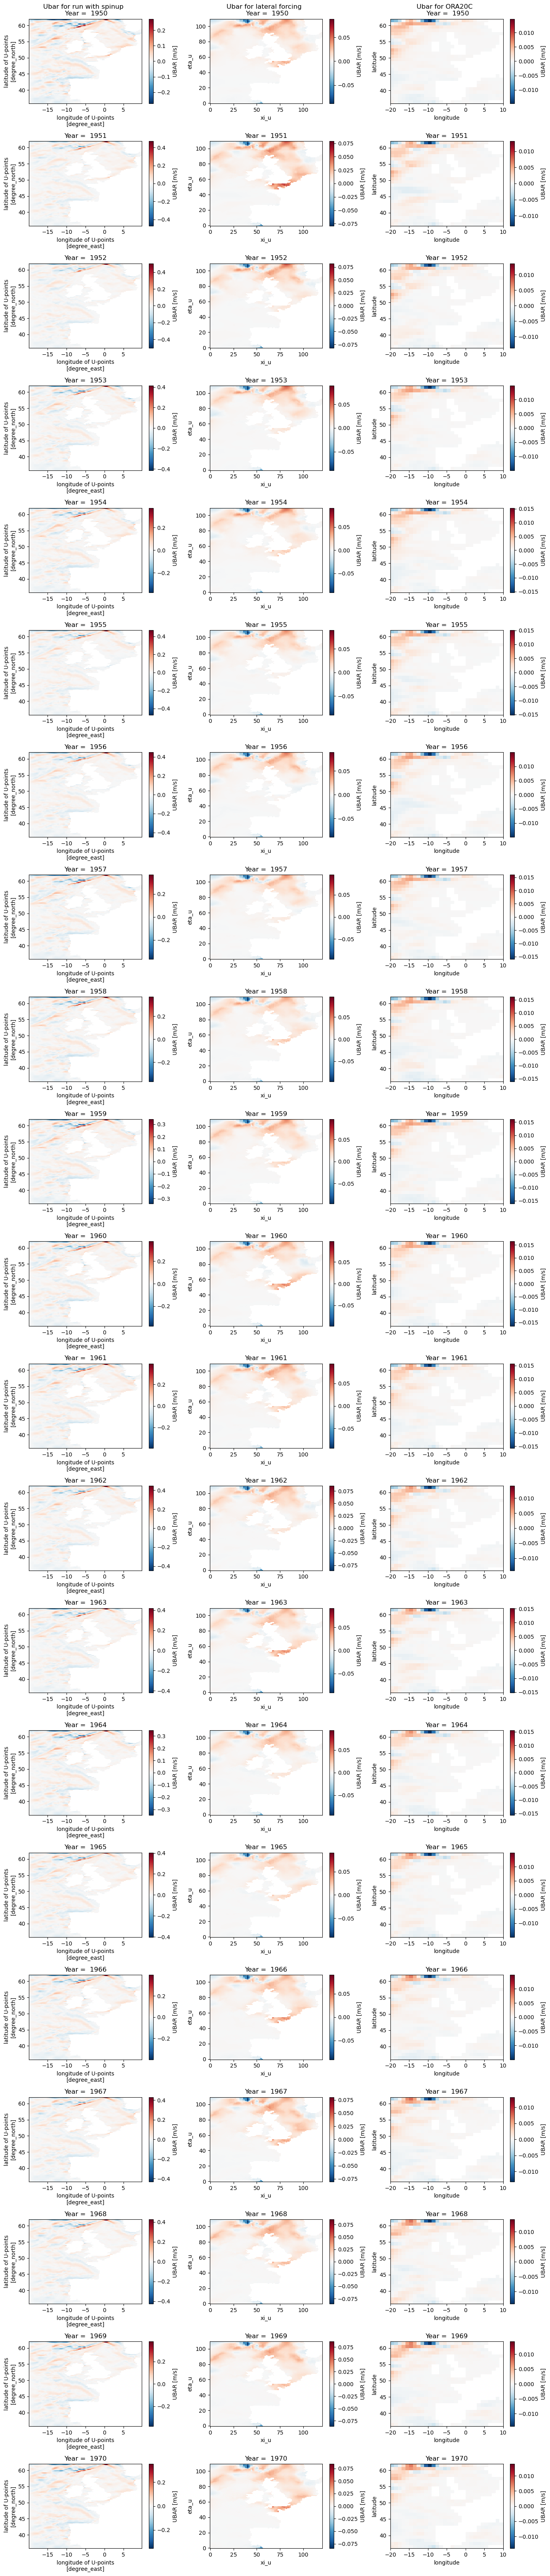

In [110]:
nrows = run3_year.ocean_time.size

fig, axes = plt.subplots(ncols = 3, nrows = nrows, figsize = (14, 3.1*nrows))

for i in range(nrows):
    
    # Plot ubar
    
    run3_year.ubar.isel(ocean_time = i).plot(ax = axes[i, 0], y='lat_u', x='lon_u', cbar_kwargs={"label": "UBAR [m/s]"})
    
    if i == 0:
        axes[i, 0].set_title(f'Ubar for run with spinup  \n Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    else:
        axes[i, 0].set_title(f'Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    
    
    clim_year.ubar.isel(ocean_time = i).plot(ax = axes[i, 1], cbar_kwargs={"label": "UBAR [m/s]"})
    
    if i == 0:
        axes[i, 1].set_title(f'Ubar for lateral forcing  \n Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    else:
        axes[i, 1].set_title(f'Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    
    
    
    
    
    ora_UBAR.isel(time = i).plot(ax = axes[i, 2], cbar_kwargs={"label": "UBAR [m/s]"})
    
    if i == 0:
        axes[i, 2].set_title(f'Ubar for ORA20C  \n Year =  {ora_UBAR.time.isel(time=i).dt.year}')
    
    else:
        axes[i, 2].set_title(f'Year =  {ora_UBAR.time.isel(time=i).dt.year}')
    
    
    
    plt.tight_layout()

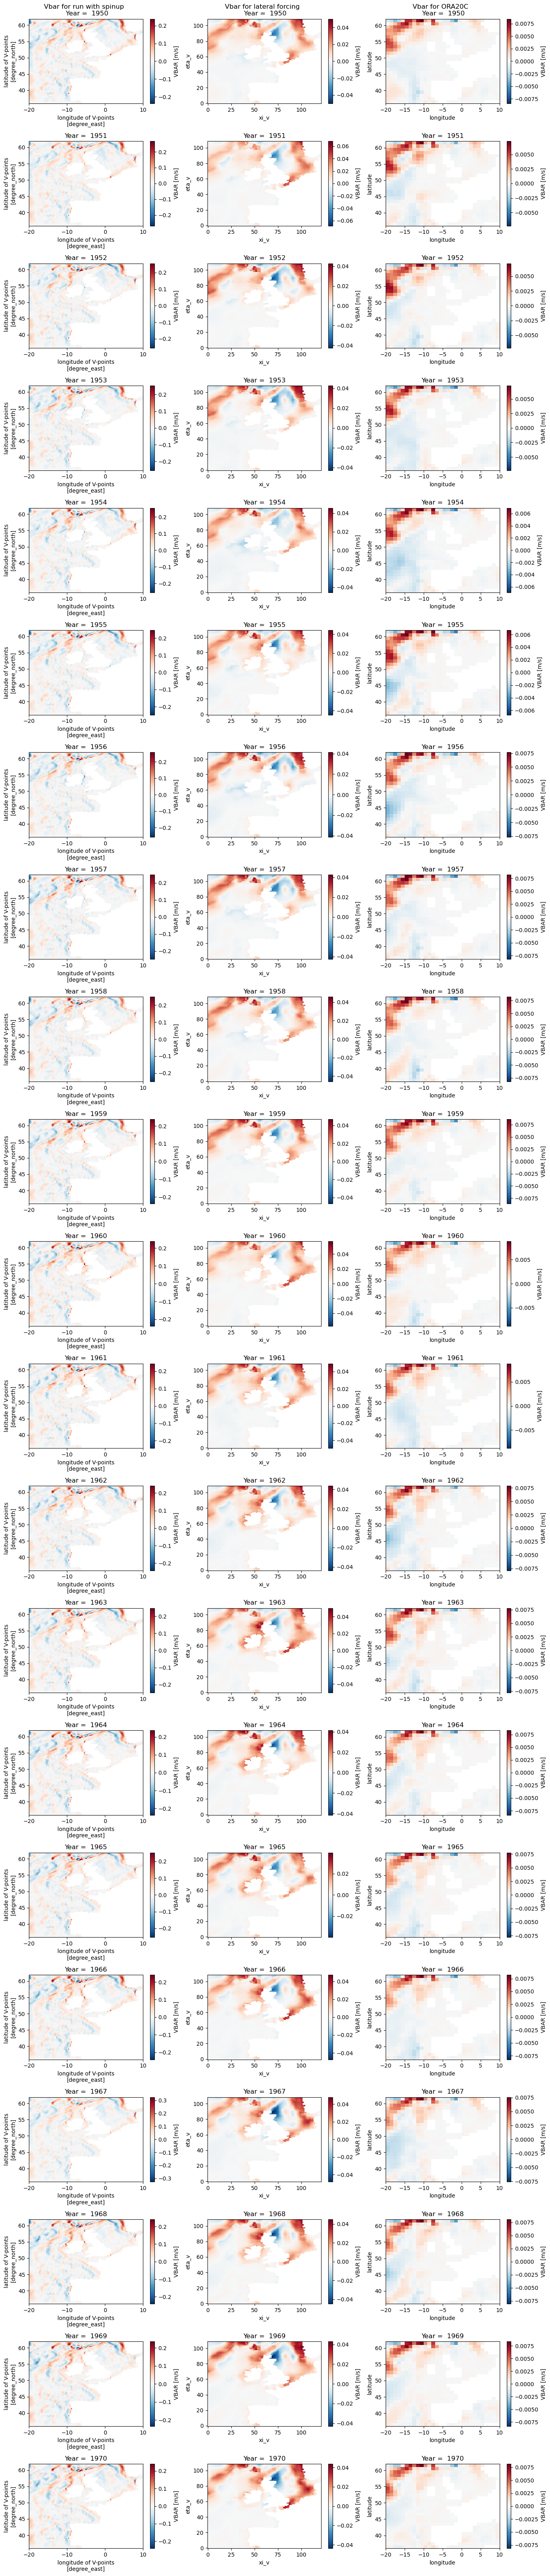

In [112]:
nrows = run3_year.ocean_time.size

fig, axes = plt.subplots(ncols = 3, nrows = nrows, figsize = (14, 3.1*nrows))

for i in range(nrows):
    
    # Plot vbar
    
    run3_year.vbar.isel(ocean_time = i).plot(ax = axes[i, 0], y='lat_v', x='lon_v', cbar_kwargs={"label": "VBAR [m/s]"})
    
    if i == 0:
        axes[i, 0].set_title(f'Vbar for run with spinup  \n Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    else:
        axes[i, 0].set_title(f'Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    
    
    clim_year.vbar.isel(ocean_time = i).plot(ax = axes[i, 1], cbar_kwargs={"label": "VBAR [m/s]"})
    
    if i == 0:
        axes[i, 1].set_title(f'Vbar for lateral forcing  \n Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    else:
        axes[i, 1].set_title(f'Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    
    
    
    
    
    ora_VBAR.isel(time = i).plot(ax = axes[i, 2], cbar_kwargs={"label": "VBAR [m/s]"})
    
    if i == 0:
        axes[i, 2].set_title(f'Vbar for ORA20C  \n Year =  {ora_UBAR.time.isel(time=i).dt.year}')
    
    else:
        axes[i, 2].set_title(f'Year =  {ora_UBAR.time.isel(time=i).dt.year}')
    
    
    
    plt.tight_layout()

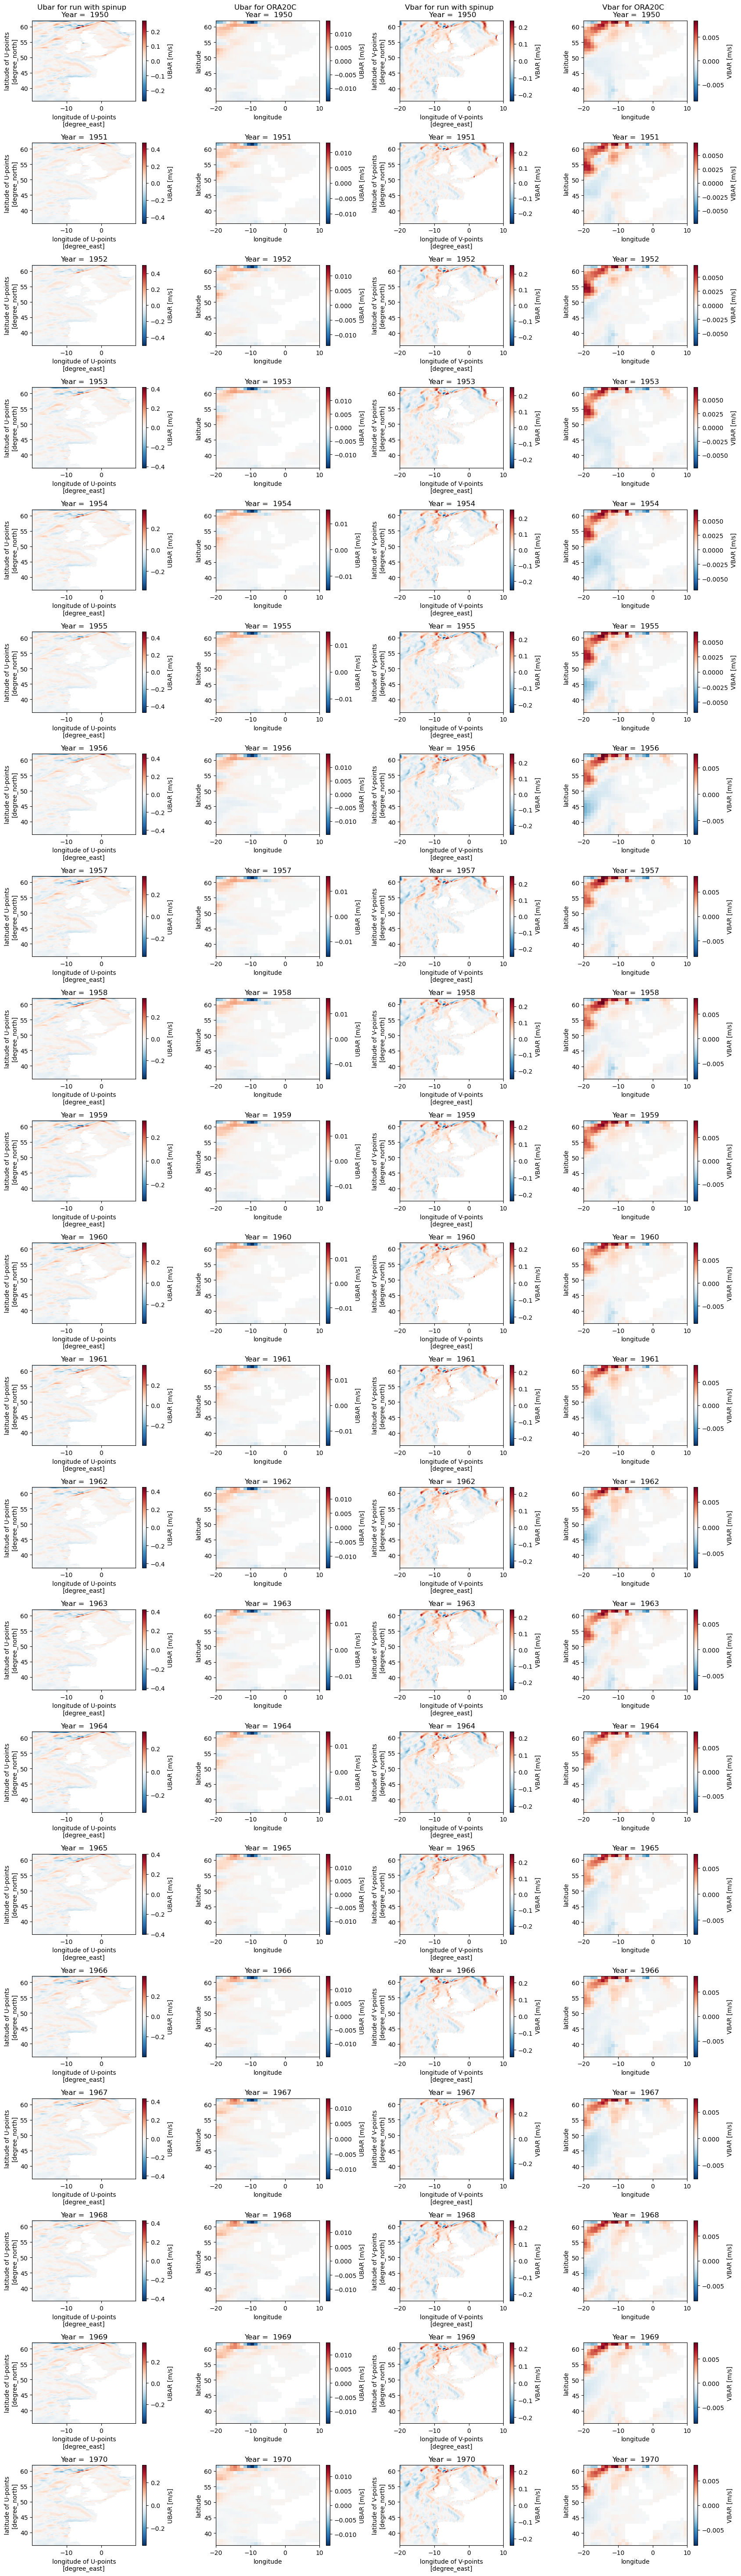

In [101]:
nrows = run3_year.ocean_time.size

fig, axes = plt.subplots(ncols = 4, nrows = nrows, figsize = (17, 2.8*nrows))

for i in range(nrows):
    
    # Plot ubar
    
    run3_year.ubar.isel(ocean_time = i).plot(ax = axes[i, 0], y='lat_u', x='lon_u', cbar_kwargs={"label": "UBAR [m/s]"})
    
    if i == 0:
        axes[i, 0].set_title(f'Ubar for run with spinup  \n Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    else:
        axes[i, 0].set_title(f'Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    
    
    ora_UBAR.isel(time = i).plot(ax = axes[i, 1], cbar_kwargs={"label": "UBAR [m/s]"})
    
    if i == 0:
        axes[i, 1].set_title(f'Ubar for ORA20C  \n Year =  {ora_UBAR.time.isel(time=i).dt.year}')
    
    else:
        axes[i, 1].set_title(f'Year =  {ora_UBAR.time.isel(time=i).dt.year}')
    
    
    
    
    
    # Plot vbar
    
    run3_year.vbar.isel(ocean_time = i).plot(ax = axes[i, 2], y='lat_v', x='lon_v', cbar_kwargs={"label": "VBAR [m/s]"})
    
    if i == 0:
        axes[i, 2].set_title(f'Vbar for run with spinup  \n Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    else:
        axes[i, 2].set_title(f'Year =  {run3_year.ocean_time.isel(ocean_time=i).dt.year}')
    
    
    
    ora_VBAR.isel(time = i).plot(ax = axes[i, 3], cbar_kwargs={"label": "VBAR [m/s]"})
    
    if i == 0:
        axes[i, 3].set_title(f'Vbar for ORA20C  \n Year =  {ora_VBAR.time.isel(time=i).dt.year}')
    
    else:
        axes[i, 3].set_title(f'Year =  {ora_VBAR.time.isel(time=i).dt.year}')
    
    
    plt.tight_layout()

In [88]:
ora_UBAR

<xarray.DataArray (time: 21, latitude: 26, longitude: 30)>
array([[[ 3.73085495e-04, -1.01747319e-04, -5.37291577e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.55197311e-04,  8.19572379e-05, -3.60254984e-04, ...,
         -3.01127584e-05,  4.11585170e-05,  1.79611598e-04],
        [ 4.03857448e-05, -1.10897505e-04, -3.20831459e-04, ...,
         -7.15610149e-05, -3.30887880e-04, -1.51777655e-04],
        ...,
        [ 3.81419761e-03,  4.48983442e-03,  4.73123835e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.12270199e-04,  1.53166382e-03,  3.01490841e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-6.89040683e-03, -6.17086003e-03, -3.70979263e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 7.17757561e-04,  3.20093328e-04, -2.79040891e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.84441902e-04,  8.33161524e-04,  4.58784460e-04, ...,
         -6.66233827e-05,  5.62229980e-05,  2.77192536e-04],
        [ 1.18424878e-05,  4.75341330e-05,  7.04557533e-05, ...,
          1.63193443e-04, -4.97681103e-05,  2.45941937e-05],
...
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.35086272e-04,  1.86949130e-03,  3.40642943e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.56496235e-03, -3.76747688e-03, -1.39755744e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.06354349e-03,  8.19822890e-04,  3.42096580e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.76581403e-04,  9.83076985e-04,  6.46209461e-04, ...,
         -1.72522763e-04, -6.68770299e-05,  5.58567772e-05],
        [ 2.48905908e-05, -1.63337554e-05, -9.61722981e-05, ...,
          3.08236864e-04,  2.80533073e-04,  2.40330206e-04],
        ...,
        [ 2.32789083e-03,  2.37012119e-03,  2.54541473e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.47528446e-04,  1.44236162e-03,  2.70061987e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.25252272e-03, -3.09086451e-03, -6.65006810e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -19.5 -18.5 -17.5 -16.5 ... 6.5 7.5 8.5 9.5
  * latitude   (latitude) float32 36.5 37.5 38.5 39.5 ... 58.5 59.5 60.5 61.5
  * time       (time) datetime64[ns] 1950-12-31 1951-12-31 ... 1970-12-31